In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
import glob

In [ ]:
import xml.etree.ElementTree as ET
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
randomseed=22
print('random seed: ', randomseed)
random.seed(randomseed)
torch.manual_seed(randomseed)
torch.use_deterministic_algorithms(True)

random seed:  22


## Data:[Kaggle] Generative Dog Images

5922 dog image,   
120 classes

preprocess:
1. img 속 bounding box에 맞춰 crop 후 64x64 resize(배경정보 제거)
2. 단일 img 속 dog object가 다수라면, 1과정을 통해 각각의 단일 data로 쪼갬
3.

after data preprocessing;  


In [ ]:
dataroot="/content/drive/MyDrive/GAN_dog"

In [ ]:
img_filename=dataroot+'/all-dogs'
img_filenames = os.listdir(img_filename)
len(img_filenames)

5922

In [ ]:
#img_filenames

In [ ]:
PATH_ANNOTATION=dataroot+'/Annotation'
breeds = glob.glob(PATH_ANNOTATION+'*')
annotations = []
for breed in breeds:
    annotations += glob.glob(breed+'/*')
len(annotations)

120

In [ ]:
#annotations
#>'/content/drive/MyDrive/GAN_dog/Annotation/n02100583-vizsla',
# '/content/drive/MyDrive/GAN_dog/Annotation/n02105412-kelpie',
# '/content/drive/MyDrive/GAN_dog/Annotation/n02092339-Weimaraner',
# '/content/drive/MyDrive/GAN_dog/Annotation/n02107312-miniature_pinscher',

In [ ]:
# Annotation 속 class name parsing 후 class 수 계산
breed_map={}
for annotation in annotations:
  breed=annotation.split('/')[-1] # 02105412-kelpie
  index = breed.split('-')[0] # ex) n02105412
  breed_map.setdefault(index,breed)

n_classes=len(breed_map)
n_classes

120

In [ ]:
#breed_map
#>'n02105412': 'n02105412-kelpie',
# 'n02092339': 'n02092339-Weimaraner',
# 'n02107312': 'n02107312-miniature_pinscher',

In [ ]:
# Annotation folder 속 각 data에 대한 JSON 파일의 object 위치 정보 추출
def bounding_box(img_path):
  bpath=os.path.join(PATH_ANNOTATION, str(breed_map[img_path.split('_')[0]]), str(img_path.split('.')[0]))

  #JSON obeject bbx context Parsing
  tree =ET.parse(bpath)
  root=tree.getroot()
  objects=root.findall('object')

  bbx_ratios=[]
  bbxs=[]
  for o in objects:
    bnd_box=o.find('bndbox')
    xmin = int(bnd_box.find('xmin').text)
    ymin = int(bnd_box.find('ymin').text)
    xmax = int(bnd_box.find('xmax').text)
    ymax = int(bnd_box.find('ymax').text)
    xlen = xmax - xmin
    ylen = ymax - ymin
    ratio = ylen / xlen

    bbxs.append((xmin,ymin,xmax,ymax))
    bbx_ratios.append((xlen,ylen,ratio))

  return bbxs, bbx_ratios

In [ ]:
# bounding_box function을 통해 단일 img 속 objects 추출 및 index 작업
# ex) /n02105412-1 , /n02105412-2

img_filenames_th=[]
img_filenames2=[]
ratios_th=[]

for img in tqdm(img_filenames):
  try:
    bbxs, bbx_ratios=bounding_box(img)
    img_filenames2.append(img)
  except:
    continue

  for i,(_,_,ratio) in enumerate(bbx_ratios):
    if ((ratio>0.2)&(ratio<4.0)):
      img_filenames_th.append(img[:-4]+'_'+str(i)+'.jpg')
      ratios_th.append(ratio)

ratios_th = np.array(ratios_th)

100%|██████████| 5922/5922 [19:53<00:00,  4.96it/s]


In [ ]:
print(len(img_filenames2))
print(len(img_filenames_th))

5234
5625


In [ ]:
from PIL import Image,ImageOps,ImageEnhance

In [ ]:
def data_preprocessing(img_path,bbx_idx):
    bbx = bounding_box(img_path)[0][bbx_idx]
    img  = Image.open(os.path.join(img_filename,img_path)) #PILImage format
    img_cropped  = img.crop(bbx)
    return img_cropped

In [ ]:
# class에 index 부여
breed_map_2 = {}
for i,b in enumerate(breed_map.keys()):
    breed_map_2[b] = i

In [ ]:
len(breed_map_2)

120

In [ ]:
#제외목록
#from https://www.kaggle.com/korovai/dogs-images-intruders-extraction
intruders = [
    #n02088238-basset
    'n02088238_10870_0.jpg',

    #n02088466-bloodhound
    'n02088466_6901_1.jpg',
    'n02088466_6963_0.jpg',
    'n02088466_9167_0.jpg',
    'n02088466_9167_1.jpg',
    'n02088466_9167_2.jpg',

    #n02089867-Walker_hound
    'n02089867_2221_0.jpg',
    'n02089867_2227_1.jpg',

    #n02089973-English_foxhound # No details
    'n02089973_1132_3.jpg',
    'n02089973_1352_3.jpg',
    'n02089973_1458_1.jpg',
    'n02089973_1799_2.jpg',
    'n02089973_2791_3.jpg',
    'n02089973_4055_0.jpg',
    'n02089973_4185_1.jpg',
    'n02089973_4185_2.jpg',

    #n02090379-redbone
    'n02090379_4673_1.jpg',
    'n02090379_4875_1.jpg',

    #n02090622-borzoi # Confusing
    'n02090622_7705_1.jpg',
    'n02090622_9358_1.jpg',
    'n02090622_9883_1.jpg',

    #n02090721-Irish_wolfhound # very small
    'n02090721_209_1.jpg',
    'n02090721_1222_1.jpg',
    'n02090721_1534_1.jpg',
    'n02090721_1835_1.jpg',
    'n02090721_3999_1.jpg',
    'n02090721_4089_1.jpg',
    'n02090721_4276_2.jpg',

    #n02091032-Italian_greyhound
    'n02091032_722_1.jpg',
    'n02091032_745_1.jpg',
    'n02091032_1773_0.jpg',
    'n02091032_9592_0.jpg',

    #n02091134-whippet
    'n02091134_2349_1.jpg',
    'n02091134_14246_2.jpg',

    #n02091244-Ibizan_hound
    'n02091244_583_1.jpg',
    'n02091244_2407_0.jpg',
    'n02091244_3438_1.jpg',
    'n02091244_5639_1.jpg',
    'n02091244_5639_2.jpg',

    #n02091467-Norwegian_elkhound
    'n02091467_473_0.jpg',
    'n02091467_4386_1.jpg',
    'n02091467_4427_1.jpg',
    'n02091467_4558_1.jpg',
    'n02091467_4560_1.jpg',

    #n02091635-otterhound
    'n02091635_1192_1.jpg',
    'n02091635_4422_0.jpg',

    #n02091831-Saluki
    'n02091831_1594_1.jpg',
    'n02091831_2880_0.jpg',
    'n02091831_7237_1.jpg',

    #n02092002-Scottish_deerhound
    'n02092002_1551_1.jpg',
    'n02092002_1937_1.jpg',
    'n02092002_4218_0.jpg',
    'n02092002_4596_0.jpg',
    'n02092002_5246_1.jpg',
    'n02092002_6518_0.jpg',

    #02093256-Staffordshire_bullterrier
    'n02093256_1826_1.jpg',
    'n02093256_4997_0.jpg',
    'n02093256_14914_0.jpg',

    #n02093428-American_Staffordshire_terrier
    'n02093428_5662_0.jpg',
    'n02093428_6949_1.jpg'
            ]

len(intruders)

60

In [ ]:
from torch.utils.data import Dataset,DataLoader,Subset

In [ ]:
workers=2
batch_size=128
img_size=64
n_ch=3

In [ ]:

class DogDataset(Dataset):
  def __init__(self, path, img_list, transform1=None, transform2=None):
    self.path=path
    self.img_list=img_list
    self.transform1=transform1
    self.transform2=transform2

    self.imgs=[]
    self.labels=[]

    for i, full_img_path in tqdm(enumerate(self.img_list)):
      if full_img_path in intruders:
        continue

      img_path=full_img_path[:-6]+'.jpg'
      bbx_idx=int(full_img_path[-5])
      img=data_preprocessing(img_path, bbx_idx)
      if self.transform1:
        img=self.transform1(img)
      self.imgs.append(img)
      label=breed_map_2[img_path.split('_')[0]]
      self.labels.append(label)

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self,idx):
    img=self.imgs[idx]
    if self.transform2:
      img=self.transform2(img)
    label = self.labels[idx]
    return {'img':img, 'label':label}


In [ ]:
mean1,mean2,mean3=0.5,0.5,0.5
std1,std2,std3=0.5,0.5,0.5

transform1 = transforms.Compose([transforms.Resize(img_size)])

transform2 = transforms.Compose([transforms.RandomCrop(img_size),
                                 #transforms.RandomAffine(degrees=5),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 #transforms.RandomApply(random_transforms, p=0.3),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[mean1, mean2, mean3],
                                                      std=[std1, std2, std3]),
                                ])

In [ ]:
train_set = DogDataset(path=img_filename,
                       img_list=img_filenames_th,
                       transform1=transform1,
                       transform2=transform2,
                      )

5625it [16:09,  5.80it/s]


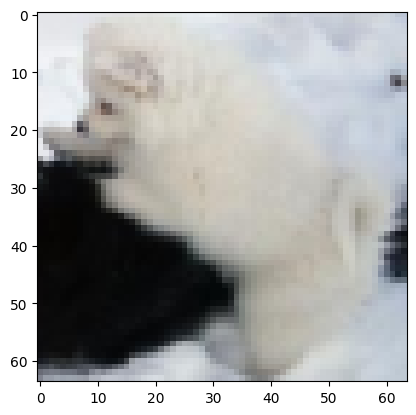

In [ ]:
img = data_preprocessing(img_filenames_th[5][:-6]+'.jpg',0)
img = transform1(img)
plt.imshow(img)

90
torch.Size([3, 64, 64])


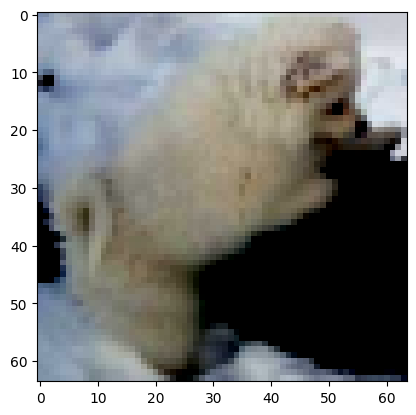

In [ ]:
sample=train_set.__getitem__(5)
print(sample['label'])
print(sample['img'].shape)
plt.imshow(sample['img'].permute(1,2,0))

In [ ]:
train_loader = DataLoader(train_set,
                          shuffle=True, batch_size=batch_size,
                          num_workers=workers, pin_memory=True)

Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

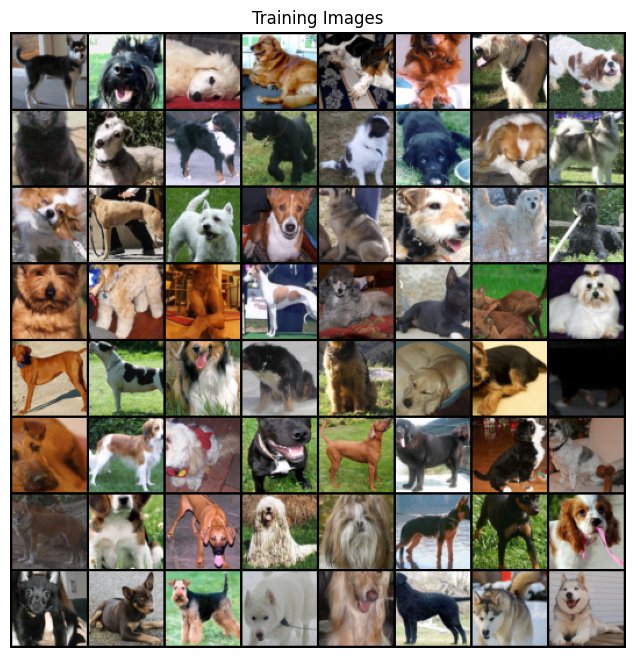

In [ ]:
real_batch = next(iter(train_loader))
#plt.imshow(real_batch['img'][0].permute(1,2,0))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch['img'].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

model

In [ ]:
n_z=100
n_gf=128
n_df=256
epochs=5
lr=0.0002
beta1=0.5
n_gpu=1

In [ ]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( n_z, n_gf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(n_gf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``

            nn.ConvTranspose2d(n_gf * 8, n_gf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_gf * 4),
            nn.BatchNorm2d(n_gf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``

            nn.ConvTranspose2d( n_gf * 4, n_gf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_gf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``

            nn.ConvTranspose2d( n_gf * 2, n_gf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_gf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``

            nn.ConvTranspose2d( n_gf, n_ch, 4, 2, 1, bias=False),
            # state size. ``(nc) x 64 x 64``

        )

        self.output = nn.Tanh()

    def forward(self, input):
      x=self.main(input)
      return self.output(x)

In [ ]:
## Create the generator
#netG = Generator(n_gpu).to(device)

## Handle multi-GPU if desired
#if (device.type == 'cuda') and (n_gpu > 1):
#    netG = nn.DataParallel(netG, list(range(n_gpu)))

## Apply the ``weights_init`` function to randomly initialize all weights
##  to ``mean=0``, ``stdev=0.02``.
#netG.apply(weights_init)

## Print the model
#print(netG)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(n_ch, n_df, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(n_df, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``

            nn.Conv2d(n_df, n_df * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(n_df * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``

            nn.Conv2d(n_df * 2, n_df * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(n_df * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``

        )
        self.output = nn.Sequential(
            # The output of D is no longer a probability, we do not apply sigmoid at the output of D.
            nn.Conv2d(in_channels=n_df * 4, out_channels=1, kernel_size=4, stride=1, padding=0))


    def forward(self, input):
      x= self.main(input)
      return self.output(x)

    def feature_extraction(self, x):
        # Use discriminator for feature extraction then flatten to vector of 16384
        x = self.main(x)
        return x.view(-1, (n_df * 4)*4*4)


In [ ]:
## Create the Discriminator
#netD = Discriminator(n_gpu).to(device)

# Handle multi-GPU if desired
#if (device.type == 'cuda') and (n_gpu > 1):
#    netD = nn.DataParallel(netD, list(range(n_gpu)))

## Apply the ``weights_init`` function to randomly initialize all weights
## like this: ``to mean=0, stdev=0.2``.
#netD.apply(weights_init)

## Print the model
#print(netD)

DCGAN

In [ ]:
## Initialize the ``BCELoss`` function
#criterion = nn.BCELoss()

## Create batch of latent vectors that we will use to visualize
##  the progression of the generator
## !!!!!
#fixed_noise = torch.randn(64, n_z, 1, 1, device=device)

## Establish convention for real and fake labels during training
#real_label = 1.
#fake_label = 0.

## Setup Adam optimizers for both G and D
#optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
#optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
from torch import Tensor
import tensorflow as tf

In [ ]:
class Logger(object):
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.create_file_writer(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        with self.writer.as_default():
            tf.summary.scalar(tag, data=value, step=step)

    def image_summary(self, tag, images, step):
        """Log a list of images.
        Args::images: numpy of shape (Batch x C x H x W) in the range [-1.0, 1.0]
        """
        with self.writer.as_default():
            imgs = None
            for i, j in enumerate(images):
                img = ((j*0.5+0.5)*255).round().astype('uint8')
                if len(img.shape) == 3:
                    img = img.transpose(1, 2, 0)
                else:
                    img = img[:, :, np.newaxis]
                img = img[np.newaxis, :]
                if not imgs is None:
                    imgs = np.append(imgs, img, axis=0)
                else:
                    imgs = img
            tf.summary.image('{}'.format(tag), imgs, max_outputs=len(imgs), step=step)

    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""
        with self.writer.as_default():
            tf.summary.histogram('{}'.format(tag), values, buckets=bins, step=step)

In [ ]:
class WGAN_GP(object):
  def __init__(self):
    print("WGAN_GradientPenalty init model.")
    self.G = Generator(n_ch)
    self.D = Discriminator(n_ch)
    self.C = n_ch

    # Check if cuda is available
    self.check_cuda(True)#args.cuda)

    # WGAN values from paper
    self.learning_rate = 1e-4
    self.b1 = 0.5
    self.b2 = 0.999
    self.batch_size = 64

    # WGAN_gradient penalty uses ADAM
    self.d_optimizer = optim.Adam(self.D.parameters(), lr=self.learning_rate, betas=(self.b1, self.b2))
    self.g_optimizer = optim.Adam(self.G.parameters(), lr=self.learning_rate, betas=(self.b1, self.b2))

    # Set the logger
    self.logger = Logger('./logs')
    self.logger.writer.flush()
    self.number_of_images = 10

    self.generator_iters =  4000 #args.generator_iters
    self.critic_iter = 5
    self.lambda_term = 10

  def get_torch_variable(self, arg): ###???????
    if self.cuda:
        return Tensor(arg).cuda(self.cuda_index)
    else:
        return Tensor(arg)

  def check_cuda(self, cuda_flag=False):
    print(cuda_flag)
    if cuda_flag:
        self.cuda_index = 0
        self.cuda = True
        self.D.cuda(self.cuda_index)
        self.G.cuda(self.cuda_index)
        #Moves all model parameters and buffers to the GPU.
        #This also makes associated parameters and buffers different objects.
        #So it should be called before constructing optimizer if the module will live on GPU while being optimized.
        print(torch.cuda.is_available())
        print("Cuda enabled flag: {}".format(self.cuda))
    else:
        self.cuda = False


  def train(self, train_loader):
    self.t_begin = t.time()
    self.file = open("inception_score_graph.txt", "w")

    # Now batches are callable self.data.next()
    self.data = self.get_infinite_batches(train_loader)


    #???
    one = torch.tensor(1, dtype=torch.float)
    mone = one * -1

    if self.cuda:
      one = one.cuda(self.cuda_index)
      mone = mone.cuda(self.cuda_index)

    #  training D for k step
    for g_iter in range(self.generator_iters):
      # Requires grad, Generator requires_grad = False
      for p in self.D.parameters():
          p.requires_grad = True

      d_loss_real = 0
      d_loss_fake = 0
      Wasserstein_D = 0
      # Train Dicriminator forward-loss-backward-update self.critic_iter times while 1 Generator forward-loss-backward-update
      for d_iter in range(self.critic_iter):
          self.D.zero_grad()

          images = self.data.__next__()
          # Check for batch to have full batch_size
          if (images.size()[0] != self.batch_size):
              continue

          z = torch.rand((self.batch_size, 100, 1, 1))

          images, z = self.get_torch_variable(images), self.get_torch_variable(z)

          # Train discriminator
          # WGAN - Training discriminator more iterations than generator
          # Train with real images
          d_loss_real = self.D(images)
          d_loss_real = d_loss_real.mean()
          d_loss_real.backward(mone)

          # Train with fake images
          z = self.get_torch_variable(torch.randn(self.batch_size, 100, 1, 1))

          fake_images = self.G(z)
          d_loss_fake = self.D(fake_images)
          d_loss_fake = d_loss_fake.mean()
          d_loss_fake.backward(one)

          # Train with gradient penalty
          gradient_penalty = self.calculate_gradient_penalty(images.data, fake_images.data)
          gradient_penalty.backward()


          d_loss = d_loss_fake - d_loss_real + gradient_penalty
          Wasserstein_D = d_loss_real - d_loss_fake
          self.d_optimizer.step()
          print(f'  Discriminator iteration: {d_iter}/{self.critic_iter}, loss_fake: {d_loss_fake}, loss_real: {d_loss_real}')

In [ ]:
generated_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs=5

In [ ]:
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):
       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data['img'].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, n_z, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            generated_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/4]	Loss_D: 1.4287	Loss_G: 4.5813	D(x): 0.4580	D(G(z)): 0.3453 / 0.0142
[1/5][0/4]	Loss_D: 0.8850	Loss_G: 5.2810	D(x): 0.6901	D(G(z)): 0.2546 / 0.0076
[2/5][0/4]	Loss_D: 0.6983	Loss_G: 5.9530	D(x): 0.6834	D(G(z)): 0.1334 / 0.0046
[3/5][0/4]	Loss_D: 0.5470	Loss_G: 8.2566	D(x): 0.8230	D(G(z)): 0.2244 / 0.0006
[4/5][0/4]	Loss_D: 0.3900	Loss_G: 7.4114	D(x): 0.8208	D(G(z)): 0.1238 / 0.0011


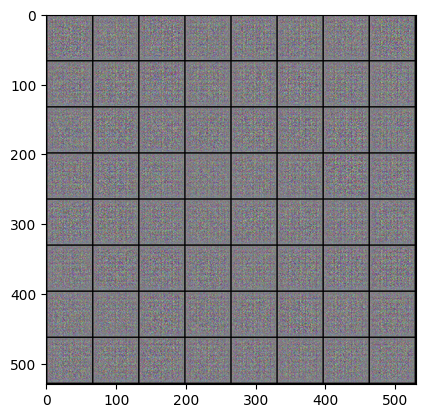

In [ ]:
plt.imshow(generated_img_list[0].permute(1,2,0))